In [2]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /Users/moguw/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


词向量
词向量通常用作下游自然语言处理（NLP）任务的基本组成部分，例如问答、文本生成、翻译等，因此，了解它们的优势和劣势非常重要。在这里，你将探索两种类型的单词向量：从共现矩阵派生的那些，以及通过GloVe派生的那些。

## Part 1: Count-Based Word Vectors

许多单词向量的实现都是基于这样一个观点：相似的词，即（近义词）会在相似的上下文中使用。因此，相似的词通常会与上下文一起被说出或写出。通过检查这些上下文，我们可以尝试为我们的单词开发嵌入。有了这种直觉，许多传统构建单词向量的方法都依赖于词计数。在这里，我们详细阐述了其中一种策略，共现矩阵

### Co-Occurrence

共现矩阵统计某些事物在某些环境中共同出现的频率。给定文档中出现的某个词 $w_i$, 	​
 ，我们考虑围绕 $w_i$ 的上下文窗口. 假设我们的固定窗口大小是 $n$, 那么这就是文档中 $n$那么这就是文档中 $w_i$ 的前 $n$ 个和后 $n$ 个词, 我们构建一个共现矩阵 $M$, 这是一个对称的词-词矩阵，其中 $M_{ij}$ 是在所有文档中，$w_j$ 出现在 $w_i$ 窗口内的词的次数.

示例：固定窗口 n=1 的共现:

Document 1: "all that glitters is not gold"
Document 2: "all is well that ends well"

|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

注意： 在自然语言处理中，我们经常添加 <START> 和 <END> 标记来代表句子、段落或文档的开始和结束。在这种情况下，我们设想每个文档都有 <START> 和 <END> 标记包裹，例如，"<START> All that glitters is not gold <END>"，并在共现计数中包含这些标记。

这个矩阵的行（或列）提供了一种类型的单词向量（基于词-词共现的），但这些向量通常很大（与语料库中不同单词的数量成线性关系）。因此，我们的下一步是进行降维。特别是，我们将执行 SVD（奇异值分解），这是一种泛化的 PCA（主成分分析），用于选择前 $k$ 个主要成分。这里有一个SVD降维的可视化。在这张图中，我们的共现矩阵是 $A$，有 $n$ 行，对应于 $n$ 个词. 我们获得了一个完整的矩阵分解，奇异值按对角线 $S$ 矩阵排序，我们的新的长度为 $k$ 的单词向量在 $U_k$ 中.

![Picture of an SVD](svd.png "SVD")

这种降维后的共现表示保留了词之间的语义关系，例如，doctor 和 hospital 会比 doctor 和 dog 更接近。

### Plotting Co-Occurrence Word Embeddings

在这里，我们将使用路透社（商业和财经新闻）语料库。如果你还没有运行本页顶部的导入单元，请现在运行它（点击它并按SHIFT-RETURN）。该语料库包含10,788篇新闻文档，总计130万字。这些文档涵盖了90个类别，并被分为训练集和测试集。有关更多详细信息，请参阅 https://www.nltk.org/book/ch02.html。我们提供了一个`read_corpus`函数，该函数仅提取“黄金”（即关于黄金、采矿等的新闻文章）类别的文章。该函数还在每个文档中添加了`和`标记，并将所有单词转换为小写。你不需要执行任何其他类型的预处理。

In [3]:
def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

让我们看看这些文档是什么样子的……

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western',
  'mining', 'corp', 'holdings', 'ltd', '&', 'lt', ';', 'wmng', '.', 's', '>', '(', 'wmc', ')',
  'said', 'it', 'will', 'establish', 'a', 'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the',
  'northern', 'territory', 'at', 'a', 'cost', 'of', 'about', '21', 'mln', 'dlrs', '.', 'the',
  'mine', ',', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', ',', 'will', 'be', 'owned',
  '60', 'pct', 'by', 'wmc', 'and', '40', 'pct', 'by', 'a', 'local', 'w', '.', 'r', '.', 'grace',
  'and', 'co', '&', 'lt', ';', 'gra', '>', 'unit', '.', 'it', 'is', 'located', '30', 'kms', 'east',
  'of', 'the', 'adelaide', 'river', 'at', 'mt', '.', 'bundey', ',', 'wmc', 'said', 'in', 'a',
  'statement', 'it', 'said', 'the', 'open', '-', 'pit', 'mine', ',', 'with', 'a', 'conventional',
  'leach', 'treatment', 'plant', ',', 'is', 'expected', 'to', 'produce', 'about', '50', ',', '000',
  'ounces', 'of', 'gold'

### Question 1.1: Implement `distinct_words`

编写一个方法来计算语料库中出现的不重复单词（单词类型）。你可以使用 for 循环来做这件事，但使用 Python 列表推导式会更高效。特别是，这篇文章 可能对一维化列表中的列表很有用。如果你不熟悉 Python 列表推导式，这里有更多信息。

你返回的 corpus_words 应该是排序过的。你可以使用 Python 的 sorted 函数来完成这一点。

你可能会发现使用 Python 集合 来去除重复的单词非常有用。

In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    ### SOLUTION BEGIN
    flattened_corpus = [word for document in corpus for word in document]
    distinct_words = set(flattened_corpus)
    corpus_words = sorted(distinct_words)
    n_corpus_words = len(corpus_words)
    ### SOLUTION END

    return corpus_words, n_corpus_words

In [6]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix`

编写一个方法来构建某个窗口大小 $n$（默认为4）的共现矩阵，考虑窗口中心词之前和之后的 $n$ 个词。在这里，我们开始使用 numpy (np) 来表示向量、矩阵和张量。如果你不熟悉 NumPy，cs231n 的 Python NumPy 教程 后半部分有一个 NumPy 教程。

In [7]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    ### SOLUTION BEGIN
    # init Matrix M
    M = np.zeros((n_words, n_words))
    # word2ind dictionary that maps word to index
    word2ind = {word: i for i, word in enumerate(words)}

    for document in corpus:
        for i, word in enumerate(document):
            # Loop through the context window
            for j in range(max(0, i - window_size), min(len(document), i + window_size + 1)):
                # Don't include the word itself
                if j != i:
                    M[word2ind[word], word2ind[document[j]]] += 1
    ### SOLUTION END

    return M, word2ind

In [8]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim`

构建一个方法，对矩阵执行降维以产生 k 维嵌入。使用 SVD 获取前 k 个分量，并生成一个新的 k 维嵌入矩阵。

注意： numpy、scipy 和 scikit-learn (sklearn) 都提供了 SVD 的某些实现，但只有 scipy 和 sklearn 提供了截断 SVD（Truncated SVD）的实现，并且只有 sklearn 提供了一种计算大规模截断 SVD 的高效随机算法。因此，请使用 sklearn.decomposition.TruncatedSVD。

In [9]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    ### SOLUTION BEGIN
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    ### SOLUTION END

    print("Done.")
    return M_reduced

In [10]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

在这里，你将编写一个函数来在二维空间中绘制一组二维向量。我们将使用 Matplotlib (plt) 进行绘图。

In [11]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    ### SOLUTION BEGIN
    for word in words:
        idx = word2ind[word]
        x_coords, y_coords = M_reduced[idx]
        plt.scatter(x_coords, y_coords, marker='x', color='red')
        plt.annotate(word, (x_coords, y_coords), fontsize=9)
    plt.show()
    ### SOLUTION END

--------------------------------------------------------------------------------
Outputted Plot:


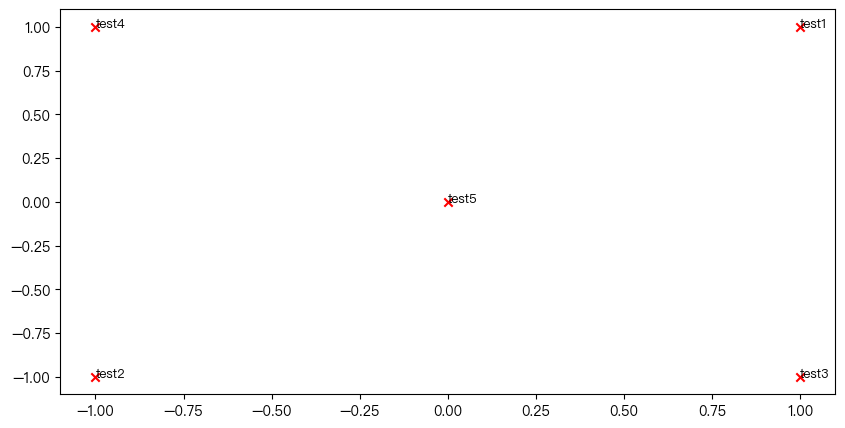

--------------------------------------------------------------------------------


In [12]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-Occurrence Plot Analysis

现在我们将整合你所编写的所有部分！我们将在路透社 "gold" 语料库上计算固定窗口大小为 4 的共现矩阵。然后我们将使用截断 SVD 计算每个词的二维嵌入。截断 SVD 返回 U*S，因此我们需要规范化返回的向量，以便所有向量都出现在单位圆附近（因此接近度是方向上的接近度）。注意：下面进行规范化的代码行使用了 NumPy 的 广播 概念。如果你不了解广播，请查看 数组计算：Jake VanderPlas 的广播。

Running Truncated SVD over 2830 words...
Done.


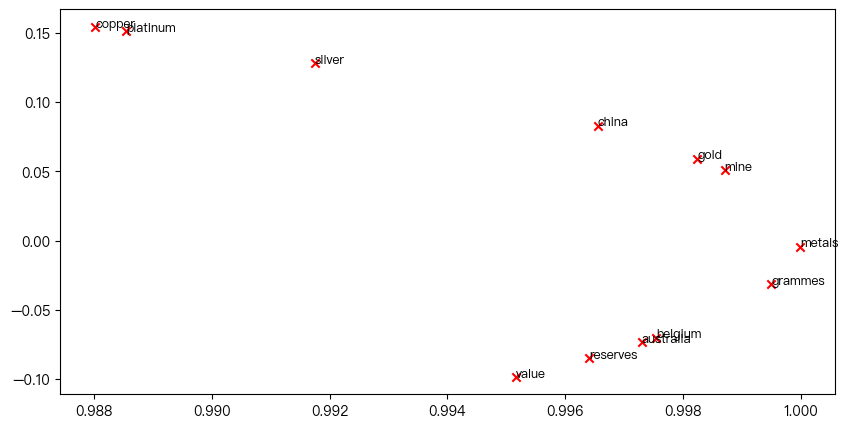

In [13]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

![question 1.5 plot](question_1.5.png)

a. 在二维嵌入空间中，至少找到两组聚集在一起的单词群组。对每个观察到的群组给出解释。

### SOLUTION BEGIN
在这个二维嵌入空间中，可以清晰地检测到三个群组，分别是 [["copper", "platinum"], ["gold", "mine"], ["australia", "belgium"]]。

1. 第一个群组由两种金属组成，它们都是过渡金属，具有相似的属性，如高熔点、导电性和耐腐蚀性。铜（"copper"）和铂（"platinum"）在化学元素周期表中都属于过渡金属，它们在工业和自然界中都有广泛的应用和相似的化学性质。

2. 第二个群组相当明显，因为黄金（"gold"）通常是从矿山（"mine"）中开采出来的。这个群组展示了 "gold" 和 "mine" 这两个词在语料库中的共现关系，因为它们在文本中经常一起出现，描述黄金开采的上下文。

3. 第三个群组包含两个国家，它们都拥有重要的金属产业。比利时（"belgium"）以其钢铁工业闻名，而澳大利亚（"australia"）是黄金、铁矿石和其他矿物的主要生产国。这个群组揭示了这两个国家在金属产业方面的语义联系。

### SOLUTION END
这个解决方案提供了对二维嵌入空间中单词群组的合理解释，展示了如何根据单词的语义关系和现实世界中的联系来分析嵌入结果。

b. 有哪些词没有聚集在一起，但你可能认为它们应该聚集？描述至少两个例子。

### SOLUTION BEGIN
我认为铜、铂、银和金（也许还包括其他金属）应该在嵌入空间中聚集在一起，因为它们都是金属。
此外，我原本期望所有国家，如中国、比利时和澳大利亚会聚集在一起。但是，只有比利时和澳大利亚聚集在一起，而中国却相距甚远。
### SOLUTION END

## Part 2: Prediction-Based Word Vectors (15 points)

正如课堂上所讨论的，最近基于预测的单词向量已经展示了更好的性能，比如 word2vec 和 GloVe（它也利用了计数的优势）。在这里，我们将探索由 GloVe 生成的嵌入。请重新查看课堂笔记和讲座幻灯片，以获取有关 word2vec 和 GloVe 算法的更多详细信息。如果你愿意接受挑战，尝试阅读 GloVe 的原始论文。

然后运行以下单元格，将 GloVe 向量加载到内存中。注意：如果这是你第一次运行这些单元格，即下载嵌入模型，它将需要几分钟的时间来运行。如果你之前运行过这些单元格，重新运行它们将加载模型而不需要重新下载，这将需要大约 1 到 2 分钟。

In [14]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [15]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


### Reducing dimensionality of Word Embeddings
让我们直接比较 GloVe 嵌入与共现矩阵嵌入。为了避免内存不足，我们将只使用 10000 个 GloVe 向量的样本。请按照以下步骤操作：

1. 将 10000 个 GloVe 向量放入一个名为 M 的矩阵中。
2. 运行 reduce_to_k_dim（你的截断 SVD 函数），将这些向量从 200 维降到 2 维。

In [17]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [18]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


### Question 2.1: GloVe Plot Analysis

运行下面的单元格，以绘制 ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"] 的 2D GloVe 嵌入。

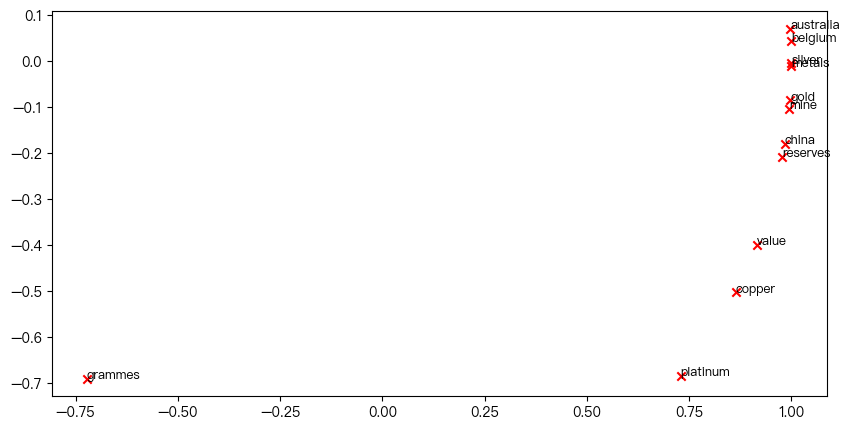

In [19]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_reduced_normalized, word2ind, words)

a. 与之前通过共现矩阵生成的图表相比，一个不同点是什么？一个相同点是什么？

### SOLUTION BEGIN
GloVe 图表有两个在共现矩阵图表中没有出现的群组。这里，"china"（中国）和 "reserves"（储备）构成了一个群组，"silver"（银）和 "metals"（金属）是另一个。此外，"copper"（铜）和 "platinum"（铂）现在彼此相距太远，以至于不能称它们为一个群组。

与共现矩阵图表相似的是 "australia"（澳大利亚）、"belgium"（比利时）和 "gold"（黄金）、"mine"（矿山）这些词形成的群组。
### SOLUTION END

b. 造成这种差异的一个可能原因是什么？

### SOLUTION BEGIN
简单的共现矩阵直接统计两个词在给定语料库中一起出现的频次。因此，生成的单词嵌入仅基于这些共现计数。

另一方面，GloVe 结合了全局矩阵分解和局部上下文窗口方法来捕捉词的共现统计信息。生成的单词嵌入编码了每个词的全局和局部上下文，因此在表示词义方面有所不同。
### SOLUTION END

### Cosine Similarity
现在我们有了单词向量，我们需要一种方法来量化这些向量表示的单词之间的相似度。一种这样的度量标准是余弦相似度。我们将使用这个来找到彼此“接近”和“远离”的单词。

我们可以将 n 维向量视为 n 维空间中的点。如果我们采取这种视角，L1 范数 和 L2 范数 距离有助于量化“我们必须行进”的空间量，以在这两个点之间移动。另一种方法是检查两个向量之间的角度。从三角学我们知道：

![inner product](inner_product.png)

而不是计算实际的角度，我们可以将相似度保留为 $similarity = cos(\Theta)$. 正式地，两个向量 $p$ 和 $q$ 之间的余弦相似度 $s$ 定义为：

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 

多义词和同形异义词是具有多个含义的词（请参阅此维基页面 以了解更多关于多义词和同形异义词之间的区别）。找到一个具有至少两个不同含义的词，使得根据余弦相似度计算出的前10个最相似的词中包含来自两个含义的相关词。例如，“leaves”在前10个中既有“go_away”（离开）又有“a_structure_of_a_plant”（植物的一个结构）的含义，而“scoop”既有“handed_waffle_cone”（手持的华夫饼筒）又有“lowdown”（最新消息）的含义。你可能需要尝试几个多义词或同形异义词，才能找到一个。

请说明你发现的词以及在前10个中出现的多重含义。你认为为什么你尝试的许多多义词或同形异义词没有起作用（即前10个最相似的词只包含这些词的一个含义）？

注意：你应该使用 wv_from_bin.most_similar(word) 函数来获取前10个相似的词。这个函数根据与给定词的余弦相似度对词汇表中的所有其他词进行排名。如需进一步帮助，请查看 GenSim文档。

In [20]:
### SOLUTION BEGIN
display(wv_from_bin.most_similar("head"), wv_from_bin.most_similar("bar"))
### SOLUTION END

[('heads', 0.7668997645378113),
 ('headed', 0.6344294548034668),
 ('chief', 0.6314131021499634),
 ('body', 0.6098024249076843),
 ('assistant', 0.6064105033874512),
 ('director', 0.6037707328796387),
 ('deputy', 0.583614706993103),
 ('hand', 0.5738338232040405),
 ('left', 0.5574274659156799),
 ('arm', 0.5565925240516663)]

[('bars', 0.7344732880592346),
 ('restaurant', 0.5934867858886719),
 ('cafe', 0.5520249009132385),
 ('dining', 0.5160313844680786),
 ('pub', 0.503474235534668),
 ('lounge', 0.49940842390060425),
 ('outside', 0.4935816526412964),
 ('shop', 0.49327462911605835),
 ('where', 0.4836512804031372),
 ('restaurants', 0.48125866055488586)]

### SOLUTION BEGIN

我发现了单词 "head"，它有一个主要含义，即人类或动物的身体部位。然而，从这个主要含义辐射出其他含义，例如作为某物的顶部，如企业的老板。

许多多义词或同形异义词没有起作用，因为这个词的不同含义在关联词方面并没有很强的关联性。换句话说，这些含义之间的区别并不足以生成两组不同的关联词。例如，单词 "bar" 可以指提供饮品的地方，也可以指用来阻挡某物的物理对象，但是每个含义的关联词可能重叠太多，以至于在前10个最相似的词中都无法同时体现两者。 

### SOLUTION END

### Question 2.3: Synonyms & Antonyms 

当考虑余弦相似度时，通常更方便地考虑余弦距离，它简单地是 1 - 余弦相似度。

找到三个词 $(w_1,w_2,w_3)$ 其中 $w_1$ 和 $w_2$ 是 同义词，而 $w_1$ 和 $w_3$ 是 反义词, 但是  $(w_1,w_3) $ 的余弦相似度小于 $(w_1,w_2)$. 例如，$w_1$ ="happy" 比 $w_2$ ="cheerful" 更接近 $w_3$ ="sad"。请找到一个不同的满足上述条件的例子。一旦你找到了你的例子，请给出一个可能的解释，为什么这个违反直觉的结果可能发生了。

你应该使用 wv_from_bin.distance(w1, w2) 函数来计算两个词之间的余弦距离。

In [21]:
### SOLUTION BEGIN

w1 = "hot"
w2 = "warm"
w3 = "cold"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

### SOLUTION END

Synonyms hot, warm have cosine distance: 0.4111673831939697
Antonyms hot, cold have cosine distance: 0.40621888637542725


### SOLUTION BEGIN

这种情况可能会发生，如果语料库中包含更多将 "hot"（热）和 "cold"（冷）一起使用在对比上下文（例如 "hot and cold water"，热水和冷水）中的实例，而不是 "hot" 和 "warm"（温暖）一起使用在相似上下文中的实例（例如 "hot and warm weather"，炎热和温暖的天气）。此外，"hot" 和 "cold" 都是极端温度，而 "warm" 是较不极端的温度，所以它们不太可能在同一上下文中被使用。

另一个可能的因素是多义词或同形异义词的影响，其中一个词可能有多个含义，并且根据不同的上下文与其他词有多种关联。因此，"hot" 和 "cold" 之间的余弦相似度可能更高，导致余弦距离更小。

### SOLUTION END

### Question 2.4: Analogies with Word Vectors [written]

单词向量已被证明具有有时解决类比问题的能力。

例如，在类比 "man : grandfather :: woman : x"（读作：男人是祖父的什么，正如女人是x的什么）中，x是什么？

在下面的单元格中，我们向您展示如何使用单词向量通过 GenSim文档 中的 most_similar 函数来找到 x。该函数查找与 positive 列表中的词最相似和与 negative 列表中的词最不相似的词（同时省略输入词，它们通常是最相似的；见 这篇论文）。类比问题的答案将具有最高的余弦相似度（返回的最大数值）。

In [22]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.644535481929779)]


设 $m$, $g$, $w$, 和 $x$ 分别表示 `man`, `grandfather`, `woman`, 和答案的单词向量。仅使用向量  $m$, $g$, $w$, 和向量算术运算符 $+$ and $-$, 我们要最大化 $x$ 的余弦相似度的表达式是什么？

### SOLUTION BEGIN
$x = w + g - m$
### SOLUTION END

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
a. 对于前一个例子，很明显 "grandmother"（祖母）完成了这个类比。但是，给一个直观的解释，为什么 most_similar 函数会给我们像 "granddaughter"（孙女）、"daughter"（女儿）或 "mother"（母亲）这样的词？

### SOLUTION BEGIN
直观的解释是，与“grandmother”（祖母）最相似且因此距离最近的词是“granddaughter”（孙女）、“daughter”（女儿）或“mother”（母亲）。
### SOLUTION END

b. 找到一个根据这些向量成立的类比示例（即预期的词排在首位）。在你的解决方案中，请以 x:y :: a:b 的形式陈述完整的类比。如果你认为类比很复杂，请用一两句话解释为什么这个类比成立。

In [23]:
### SOLUTION BEGIN

x, y, a, b = "earth", "moon", "saturn", "enceladus"
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

### SOLUTION END

### Question 2.6: Incorrect Analogy [code + written]

a. 在下面，我们期望看到预期的类比 "hand : glove :: foot : sock"，但我们却看到了一个意想不到的结果。给一个可能的原因，解释为什么这个特定的类比会有这样的结果？

In [24]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032058238983),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.45447564125061035),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.4441334009170532),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.43563973903656006),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596625804901),
 ('footed', 0.43236875534057617)]


### SOLUTION BEGIN
类比 "hand : glove :: foot : 45,000-square" 的意外结果可能是由于用于训练单词向量的语料库造成的。输出表明，单词向量模型可能没有在一个足够多样化的语料库上训练，或者它可能没有在正确类型的文本数据上训练，以捕捉所需的类比。也有可能在训练数据中，"foot" 和 "sock" 之间的关系的示例根本不够多，以至于单词向量模型无法识别这种类比。
### SOLUTION END

b. 找到一个根据这些向量不成立的类比示例。在你的解决方案中，请以 x:y :: a:b 的形式陈述预期的类比，并说明根据单词向量得出的 b 的错误值（在前一个例子中，这将是 '45,000平方米'）。

In [25]:
### SOLUTION BEGIN

x, y, a, b = "car", "tire", "plane", "wing"
pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))

### SOLUTION END

[('flight', 0.5433245301246643),
 ('airplane', 0.5250508785247803),
 ('landing', 0.5006207823753357),
 ('aircraft', 0.4719180464744568),
 ('takeoff', 0.4702064096927643),
 ('egyptair', 0.46068817377090454),
 ('planes', 0.4578590989112854),
 ('jet', 0.4512889087200165),
 ('airlines', 0.450116902589798),
 ('tires', 0.4496222138404846)]


### SOLUTION BEGIN
**intended:**
car : tire :: plane : wing

**incorrect value of b:**
flight
### SOLUTION END

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

我们必须意识到我们的单词嵌入中隐含的偏见（性别、种族、性取向等）。偏见可能是危险的，因为它可以通过使用这些模型的应用来强化刻板印象。

运行下面的单元格，检查 (a) 与 "woman"（女人）和 "profession"（职业）最相似且与 "man"（男人）最不相似的术语，以及 (b) 与 "man"（男人）和 "profession"（职业）最相似且与 "woman"（女人）最不相似的术语。指出与女性相关的词汇列表和与男性相关的词汇列表之间的差异，并解释它如何反映了性别偏见。

In [26]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.487585186958313),
 ('respected', 0.485920250415802),
 ('practice', 0.4821045696735382),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957458019256592),
 ('practitioner', 0.4988412857055664),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.4693780839443207),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995656967163),
 ('professionals', 0.46013936400413513)]


### SOLUTION BEGIN

两个列表之间的主要区别在于，第一个列表（与“男人”和“职业”最相似）大多与个人在职业中所具有的高期望品质或声誉相关，而第二个列表则大多与社会部门的低薪工作相关。这些词汇并不一定与特定性别有关，可以适用于任何职业人士。然而，它们被列为与“男人”而非“女人”最相似的事实，意味着单词嵌入模型已经学习到了一个性别刻板印象，即男性比女性更有可能拥有这些品质。

### SOLUTION END

### Question 2.8: Independent Analysis of Bias in Word Vectors

使用 most_similar 函数找到另一对类比，以证明向量表现出某种偏见。请简要解释您发现的偏见示例。

In [27]:
### SOLUTION BEGIN

A = "mexican"
B = "european"
word = "migrant"
pprint.pprint(wv_from_bin.most_similar(positive=[A, word], negative=[B]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[B, word], negative=[A]))

### SOLUTION END

[('undocumented', 0.6107112765312195),
 ('laborers', 0.5217877626419067),
 ('migrants', 0.5125507712364197),
 ('farmworkers', 0.5082622766494751),
 ('chiapas', 0.49977296590805054),
 ('immigrant', 0.49870046973228455),
 ('mexicans', 0.4962908625602722),
 ('filipino', 0.4942995607852936),
 ('farmworker', 0.49109315872192383),
 ('tijuana', 0.48279839754104614)]

[('eu', 0.5639792084693909),
 ('europe', 0.5121256113052368),
 ('migrants', 0.48573097586631775),
 ('countries', 0.46824532747268677),
 ('labour', 0.4666498303413391),
 ('laborers', 0.45544111728668213),
 ('union', 0.44518330693244934),
 ('labourers', 0.4433914124965668),
 ('seekers', 0.44145190715789795),
 ('organisation', 0.4389623999595642)]


### SOLUTION BEGIN

墨西哥移民似乎经常出现在与客观上负面的词汇如“无证件”和“农场工人”相关的语境中，而欧洲移民则没有与负面词汇相关联。这暗示了向量中存在的文化偏见。

### SOLUTION END

### Question 2.9: Thinking About Bias

a. 解释一种偏见如何进入词向量。简要描述一个展示此偏见来源的现实例子。

### SOLUTION BEGIN

偏见进入词向量的最明显方式是来自训练文本语料库。例如，如果用于训练gensim模型的文本语料库对男性角色或观点存在偏见，那么从该模型生成的词向量可能反映了这种偏见。这意味着在向量空间中，与男性气质相关的某些词语或概念可能会更强烈地相互关联，而与女性气质相关的词语或概念可能会较弱地相互关联，甚至完全排除在向量空间之外。

一个关于这种偏见的现实例子是在一项研究中发现的，该研究分析了在Google新闻文章上训练的词嵌入模型。该研究发现，从这个数据集学习到的词向量表现出性别偏见，比如“医生”或“程序员”这样的词更倾向于与男性代词相关联，而“护士”或“家庭主妇”这样的词更倾向于与女性代词相关联。这种偏见可能会产生负面影响，比如强化刻板印象或限制不符合传统性别角色的个人的机会。

### SOLUTION END

b. 你可以用来减轻词向量展示的偏见的一个方法是使用去偏方法。简要描述一个展示这种方法的现实例子。

### SOLUTION BEGIN

去偏方法可以用来减轻词向量所展示的偏见。其简要描述如下：

去偏方法可以通过对训练数据进行平衡处理，消除或减弱其中的偏见，从而减轻词向量中的偏见。例如，在训练文本语料库中引入更多多样性和平衡性，确保各种观点和角色都得到充分体现，有助于减少偏见的产生。

一个实际的例子是，在一个研究中，研究人员使用去偏方法对训练数据进行了处理，以减轻词向量中的性别偏见。通过引入更多关于女性职业的相关语料，并确保这些语料与男性职业的语料数量相当，他们成功地减轻了词向量中关于职业与性别之间的偏见，使得这些词在向量空间中更加平衡地表示不同的角色和职业。

### SOLUTION END